(hover_dir_pad_1, hover_dir_pad_2, hover_numeric_pad)

(5 options, 5 options, 11 options) ~ 275

5 possible actions 

total 1375 state, action combinations

initial state is (A, A, A)
let's say we have to type 456A

(A, A, A)
(A, A, 4) A
(A, A, 5) A
(A, A, 6) A
(A, A, A) A


what if we're in like

(<, ^, 5) and we hit >
(A, ^, 5) and we hit >


(<, ^, 5) and we hit A?

(A, ^, 5) and we hit A?
(^, A, 5) and we hit A?
(^, >, A) and we hit A?

(A, A, 5) and we hit A?
(^, A, A) and we hit A?

(A, A, A) and we hit A?

In [68]:
# AAAAAAAAAAA0
# AAAAAAAAAAA9

In [69]:
import numpy as np

In [70]:
# input = """029A
# 980A
# 179A
# 456A
# 379A"""

input = open("inputs/21").read()

parsed_input = [list(s) for s in input.split()]

In [71]:
parsed_input

[['1', '4', '0', 'A'],
 ['1', '7', '0', 'A'],
 ['1', '6', '9', 'A'],
 ['8', '0', '3', 'A'],
 ['1', '2', '9', 'A']]

In [72]:
keypresses = parsed_input[0]
keypresses

['1', '4', '0', 'A']

In [73]:
import itertools

directional_board = np.array(
    [
        [None, "^", "A"],
        ["<", "v", ">"],
    ]
)

numeric_board = np.array(
    [
        ["7", "8", "9"],
        ["4", "5", "6"],
        ["1", "2", "3"],
        [None, "0", "A"],
    ]
)

dirs = {
    "^": (-1, 0),
    ">": (0, 1),
    "v": (1, 0),
    "<": (0, -1),
}


def in_bounds(tuple, shape):
    return 0 <= tuple[0] < shape[0] and 0 <= tuple[1] < shape[1]


def add_tuple(t1, t2):
    return tuple(map(sum, zip(t1, t2)))


def make_transition_dict(board):
    d = {}

    for i, j in np.ndindex(board.shape):
        if board[i, j] is None:
            continue

        for dir in dirs:
            new_pos = add_tuple((i, j), dirs[dir])
            d[(board[i, j], dir)] = (
                board[new_pos] if in_bounds(new_pos, board.shape) else None
            )

    return d


def manhattan_distances(array_2d: np.ndarray) -> dict:
    """
    Given a 2D NumPy array, returns a dictionary where the keys are tuples
    of two non-None elements, and the values are the Manhattan distance
    between their positions in the array.

    Each pair is represented in both orders, e.g., (A, B) and (B, A).
    """
    non_none_indices = np.argwhere(array_2d != None)
    values = array_2d[non_none_indices[:, 0], non_none_indices[:, 1]]

    elements = list(zip(values, non_none_indices[:, 0], non_none_indices[:, 1]))

    distance_dict = {}
    for (val1, row1, col1), (val2, row2, col2) in itertools.combinations(elements, 2):
        distance = abs(row1 - row2) + abs(col1 - col2)
        distance_dict[(val1, val2)] = distance
        distance_dict[(val2, val1)] = distance  # Include both directions

    return distance_dict


numeric_transition_dict = make_transition_dict(numeric_board)
directional_transition_dict = make_transition_dict(directional_board)
numeric_ds = manhattan_distances(numeric_board)
directional_ds = manhattan_distances(directional_board)

In [74]:
def get_next_state(state, action):
    *dir_hovers, num_hover = state
    dir_hovers_with_action = [action] + dir_hovers

    first_non_A_idx = next(
        (i for i, x in enumerate(dir_hovers_with_action) if x != "A"), None
    )
    # print(first_non_A_idx)

    # print(dir_hovers_with_action, first_non_A_idx)

    if first_non_A_idx is None:
        # print("emitting")
        # in this case we're emitting
        return state, num_hover

    if first_non_A_idx == len(dir_hovers_with_action) - 1:
        # print("modify num hover")
        # we modify the num_hover state
        new_num_hover = numeric_transition_dict[num_hover, dir_hovers_with_action[-1]]

        if not new_num_hover:
            return None

        return (*dir_hovers, new_num_hover), None
    else:
        # print("modify dir hover")
        # we modify the dir_hovers state
        new_dir_hovers_with_action_state = dir_hovers_with_action.copy()

        new_dir_state = directional_transition_dict[
            new_dir_hovers_with_action_state[first_non_A_idx + 1],
            new_dir_hovers_with_action_state[first_non_A_idx],
        ]

        if not new_dir_state:
            return None

        new_dir_hovers_with_action_state[first_non_A_idx + 1] = new_dir_state
        return (*new_dir_hovers_with_action_state[1:], num_hover), None

In [75]:
# sequence = "<vA<AA>>^AvAA<^A>A<v<A>>^AvA^A<vA>^A<v<A>^A>AAvA^A<v<A>A>^AAAvA<^A>A"
# sequence = "<v<A>>^AAAvA^A<vA<AA>>^AvAA<^A>A<v<A>A>^AAAvA<^A>A<vA>^A<A>A"
# sequence = "<v<A>>^A<vA<A>>^AAvAA<^A>A<v<A>>^AAvA^A<vA>^AA<A>A<v<A>A>^AAAvA<^A>A"
# sequence = "<v<A>>^AA<vA<A>>^AAvAA<^A>A<vA>^A<A>A<vA>^A<A>A<v<A>A>^AAvA<^A>A"
# sequence = "<v<A>>^AvA^A<vA<AA>>^AAvA<^A>AAvA^A<vA>^AA<A>A<v<A>A>^AAAvA<^A>A"

In [76]:
def get_possible_neighbors(state):
    for action in list(dirs.keys()) + ["A"]:
        if result := get_next_state(state, action):
            # state, emit = result
            # print(action, result)
            yield result

In [77]:
list(get_possible_neighbors(("A", "A", "A")))

[(('>', 'A', 'A'), None), (('^', 'A', 'A'), None), (('A', 'A', 'A'), 'A')]

In [78]:
# list(get_possible_neighbors(("A", "A", "A")))

In [79]:
from heapq import heappush, heappop
from collections import deque


def get_path_length_between_states(start_state, end_state):
    """bfs"""
    to_visit = deque([(start_state, 0)])
    visited = set()

    while to_visit:
        current_node, distance = to_visit.popleft()

        if current_node == end_state:
            return distance

        if current_node in visited:
            continue

        for n, _emit in get_possible_neighbors(current_node):
            to_visit.append((n, distance + 1))

        visited.add(current_node)

    return None


def get_path_between_states(start_state, end_state):
    """
    Performs BFS to find shortest path between states.
    Returns tuple of (path_length, path) if path exists, else (None, None)
    """
    to_visit = deque([(start_state, 0, [start_state])])
    visited = set()

    while to_visit:
        current_node, distance, path = to_visit.popleft()

        if current_node == end_state:
            return distance, path

        if current_node in visited:
            continue

        for n, *emit in get_possible_neighbors(current_node):
            to_visit.append((n, distance + 1, path + [n]))

        visited.add(current_node)

    return None, None


def heuristic(start, end):
    """This one is tricky. In order to transition we have to at least transition each position their Manhattan distances"""
    *start_dir_hovers, start_num_hover = start
    *end_dir_hovers, end_num_hover = end

    return sum(
        directional_ds[a, b] if a != b else 0
        for a, b in zip(start_dir_hovers, end_dir_hovers)
    ) + (
        numeric_ds[start_num_hover, end_num_hover]
        if start_num_hover != end_num_hover
        else 0
    )


def astar(start, goal):
    # Priority queue entries are (f_score, node)
    frontier = [(0 + heuristic(start, goal), start)]
    came_from = {start: None}
    g_score = {start: 0}

    # Track nodes we've fully processed to avoid reprocessing
    processed = set()

    while frontier:
        # Get node with lowest f_score
        f_score, current = heappop(frontier)

        # If we've already found a better path to this node, skip it
        if current in processed:
            continue

        if current == goal:
            return g_score[current]

        processed.add(current)

        for neighbor, _emit in get_possible_neighbors(current):
            tentative_g = g_score[current] + 1

            if neighbor not in g_score or tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score = tentative_g + heuristic(neighbor, goal)
                heappush(frontier, (f_score, neighbor))

    return float("inf")

In [80]:
# num_robo_hover_states = 2
# num_robo_hover_states = 3
# num_robo_hover_states = 4
# num_robo_hover_states = 5
num_robo_hover_states = 6
# num_robo_hover_states = 7
# num_robo_hover_states = 25

In [81]:
start_robos = tuple("A" for _ in range(num_robo_hover_states))
start_robos

('A', 'A', 'A', 'A', 'A', 'A')

In [82]:
get_path_length_between_states(
    ("A", "A", "A", "3"), ("A", "A", "A", "6")
) + get_path_length_between_states(("A", "A", "A", "6"), ("A", "A", "A", "5"))

72

In [83]:
get_path_length_between_states(
    ("A", "A", "A", "3"), ("A", "A", "A", "2")
) + get_path_length_between_states(("A", "A", "A", "2"), ("A", "A", "A", "5"))

72

In [84]:
get_path_length_between_states(("A", "A", "A", "2"), ("A", "A", "A", "4"))


54

In [85]:
get_path_length_between_states(("A", "2"), ("A", "4"))

8

In [89]:
get_path_between_states((">", "A"), ("<", "A"))

(2, [('>', 'A'), ('v', 'A'), ('<', 'A')])

In [91]:
get_path_between_states(("A", "3"), ("A", "5"))

(8,
 [('A', '3'),
  ('>', '3'),
  ('v', '3'),
  ('<', '3'),
  ('<', '2'),
  ('v', '2'),
  ('^', '2'),
  ('^', '5'),
  ('A', '5')])

In [92]:
get_path_between_states(("A", "A", "3"), ("A", "A", "5"))

(20,
 [('A', 'A', '3'),
  ('>', 'A', '3'),
  ('v', 'A', '3'),
  ('v', '>', '3'),
  ('<', '>', '3'),
  ('<', 'v', '3'),
  ('<', '<', '3'),
  ('v', '<', '3'),
  ('^', '<', '3'),
  ('A', '<', '3'),
  ('A', '<', '2'),
  ('>', '<', '2'),
  ('>', 'v', '2'),
  ('A', 'v', '2'),
  ('^', 'v', '2'),
  ('^', '^', '2'),
  ('A', '^', '2'),
  ('A', '^', '5'),
  ('>', '^', '5'),
  ('>', 'A', '5'),
  ('A', 'A', '5')])

In [93]:
get_path_between_states(("A", "A", "A", "3"), ("A", "A", "A", "5"))

(54,
 [('A', 'A', 'A', '3'),
  ('>', 'A', 'A', '3'),
  ('v', 'A', 'A', '3'),
  ('<', 'A', 'A', '3'),
  ('<', '^', 'A', '3'),
  ('v', '^', 'A', '3'),
  ('v', 'v', 'A', '3'),
  ('^', 'v', 'A', '3'),
  ('A', 'v', 'A', '3'),
  ('A', 'v', '>', '3'),
  ('>', 'v', '>', '3'),
  ('v', 'v', '>', '3'),
  ('<', 'v', '>', '3'),
  ('<', '<', '>', '3'),
  ('v', '<', '>', '3'),
  ('^', '<', '>', '3'),
  ('A', '<', '>', '3'),
  ('A', '<', 'v', '3'),
  ('A', '<', '<', '3'),
  ('>', '<', '<', '3'),
  ('>', 'v', '<', '3'),
  ('>', '>', '<', '3'),
  ('A', '>', '<', '3'),
  ('^', '>', '<', '3'),
  ('^', 'A', '<', '3'),
  ('A', 'A', '<', '3'),
  ('A', 'A', '<', '2'),
  ('>', 'A', '<', '2'),
  ('v', 'A', '<', '2'),
  ('v', '>', '<', '2'),
  ('^', '>', '<', '2'),
  ('A', '>', '<', '2'),
  ('A', '>', 'v', '2'),
  ('>', '>', 'v', '2'),
  ('v', '>', 'v', '2'),
  ('<', '>', 'v', '2'),
  ('<', 'v', 'v', '2'),
  ('v', 'v', 'v', '2'),
  ('^', 'v', 'v', '2'),
  ('^', '^', 'v', '2'),
  ('A', '^', 'v', '2'),
  ('A', '^'

In [59]:
get_path_between_states(("A", "A", "A", "2"), ("A", "A", "A", "4"))

(54,
 [('A', 'A', 'A', '2'),
  ('>', 'A', 'A', '2'),
  ('v', 'A', 'A', '2'),
  ('<', 'A', 'A', '2'),
  ('<', '^', 'A', '2'),
  ('v', '^', 'A', '2'),
  ('v', 'v', 'A', '2'),
  ('^', 'v', 'A', '2'),
  ('A', 'v', 'A', '2'),
  ('A', 'v', '>', '2'),
  ('>', 'v', '>', '2'),
  ('v', 'v', '>', '2'),
  ('<', 'v', '>', '2'),
  ('<', '<', '>', '2'),
  ('v', '<', '>', '2'),
  ('^', '<', '>', '2'),
  ('A', '<', '>', '2'),
  ('A', '<', 'v', '2'),
  ('A', '<', '<', '2'),
  ('>', '<', '<', '2'),
  ('>', 'v', '<', '2'),
  ('>', '>', '<', '2'),
  ('A', '>', '<', '2'),
  ('^', '>', '<', '2'),
  ('^', 'A', '<', '2'),
  ('A', 'A', '<', '2'),
  ('A', 'A', '<', '1'),
  ('>', 'A', '<', '1'),
  ('v', 'A', '<', '1'),
  ('v', '>', '<', '1'),
  ('^', '>', '<', '1'),
  ('A', '>', '<', '1'),
  ('A', '>', 'v', '1'),
  ('>', '>', 'v', '1'),
  ('v', '>', 'v', '1'),
  ('<', '>', 'v', '1'),
  ('<', 'v', 'v', '1'),
  ('v', 'v', 'v', '1'),
  ('^', 'v', 'v', '1'),
  ('^', '^', 'v', '1'),
  ('A', '^', 'v', '1'),
  ('A', '^'

In [61]:
get_path_between_states(("A", "A", "A", "A", "A", "2"), ("A", "A", "A", "A", "A", "4"))

(340,
 [('A', 'A', 'A', 'A', 'A', '2'),
  ('>', 'A', 'A', 'A', 'A', '2'),
  ('v', 'A', 'A', 'A', 'A', '2'),
  ('<', 'A', 'A', 'A', 'A', '2'),
  ('<', '^', 'A', 'A', 'A', '2'),
  ('v', '^', 'A', 'A', 'A', '2'),
  ('v', 'v', 'A', 'A', 'A', '2'),
  ('^', 'v', 'A', 'A', 'A', '2'),
  ('A', 'v', 'A', 'A', 'A', '2'),
  ('A', 'v', '>', 'A', 'A', '2'),
  ('>', 'v', '>', 'A', 'A', '2'),
  ('v', 'v', '>', 'A', 'A', '2'),
  ('<', 'v', '>', 'A', 'A', '2'),
  ('<', '<', '>', 'A', 'A', '2'),
  ('v', '<', '>', 'A', 'A', '2'),
  ('^', '<', '>', 'A', 'A', '2'),
  ('A', '<', '>', 'A', 'A', '2'),
  ('A', '<', 'v', 'A', 'A', '2'),
  ('A', '<', '<', 'A', 'A', '2'),
  ('>', '<', '<', 'A', 'A', '2'),
  ('>', 'v', '<', 'A', 'A', '2'),
  ('>', '>', '<', 'A', 'A', '2'),
  ('A', '>', '<', 'A', 'A', '2'),
  ('^', '>', '<', 'A', 'A', '2'),
  ('^', 'A', '<', 'A', 'A', '2'),
  ('A', 'A', '<', 'A', 'A', '2'),
  ('A', 'A', '<', '^', 'A', '2'),
  ('>', 'A', '<', '^', 'A', '2'),
  ('v', 'A', '<', '^', 'A', '2'),
  ('v', 

In [50]:
get_path_between_states(("A", "A", "A", "3"), ("A", "A", "A", "8"))

(55,
 [('A', 'A', 'A', '3'),
  ('>', 'A', 'A', '3'),
  ('v', 'A', 'A', '3'),
  ('<', 'A', 'A', '3'),
  ('<', '^', 'A', '3'),
  ('v', '^', 'A', '3'),
  ('v', 'v', 'A', '3'),
  ('^', 'v', 'A', '3'),
  ('A', 'v', 'A', '3'),
  ('A', 'v', '>', '3'),
  ('>', 'v', '>', '3'),
  ('v', 'v', '>', '3'),
  ('<', 'v', '>', '3'),
  ('<', '<', '>', '3'),
  ('v', '<', '>', '3'),
  ('^', '<', '>', '3'),
  ('A', '<', '>', '3'),
  ('A', '<', 'v', '3'),
  ('A', '<', '<', '3'),
  ('>', '<', '<', '3'),
  ('>', 'v', '<', '3'),
  ('>', '>', '<', '3'),
  ('A', '>', '<', '3'),
  ('^', '>', '<', '3'),
  ('^', 'A', '<', '3'),
  ('A', 'A', '<', '3'),
  ('A', 'A', '<', '2'),
  ('>', 'A', '<', '2'),
  ('v', 'A', '<', '2'),
  ('v', '>', '<', '2'),
  ('^', '>', '<', '2'),
  ('A', '>', '<', '2'),
  ('A', '>', 'v', '2'),
  ('>', '>', 'v', '2'),
  ('v', '>', 'v', '2'),
  ('<', '>', 'v', '2'),
  ('<', 'v', 'v', '2'),
  ('v', 'v', 'v', '2'),
  ('^', 'v', 'v', '2'),
  ('^', '^', 'v', '2'),
  ('A', '^', 'v', '2'),
  ('A', '^'

In [56]:
get_path_between_states(("A", "A", "A", "3"), ("A", "A", "A", "7"))

(56,
 [('A', 'A', 'A', '3'),
  ('>', 'A', 'A', '3'),
  ('v', 'A', 'A', '3'),
  ('<', 'A', 'A', '3'),
  ('<', '^', 'A', '3'),
  ('v', '^', 'A', '3'),
  ('v', 'v', 'A', '3'),
  ('^', 'v', 'A', '3'),
  ('A', 'v', 'A', '3'),
  ('A', 'v', '>', '3'),
  ('>', 'v', '>', '3'),
  ('v', 'v', '>', '3'),
  ('<', 'v', '>', '3'),
  ('<', '<', '>', '3'),
  ('v', '<', '>', '3'),
  ('^', '<', '>', '3'),
  ('A', '<', '>', '3'),
  ('A', '<', 'v', '3'),
  ('A', '<', '<', '3'),
  ('>', '<', '<', '3'),
  ('>', 'v', '<', '3'),
  ('>', '>', '<', '3'),
  ('A', '>', '<', '3'),
  ('^', '>', '<', '3'),
  ('^', 'A', '<', '3'),
  ('A', 'A', '<', '3'),
  ('A', 'A', '<', '2'),
  ('A', 'A', '<', '1'),
  ('>', 'A', '<', '1'),
  ('v', 'A', '<', '1'),
  ('v', '>', '<', '1'),
  ('^', '>', '<', '1'),
  ('A', '>', '<', '1'),
  ('A', '>', 'v', '1'),
  ('>', '>', 'v', '1'),
  ('v', '>', 'v', '1'),
  ('<', '>', 'v', '1'),
  ('<', 'v', 'v', '1'),
  ('v', 'v', 'v', '1'),
  ('^', 'v', 'v', '1'),
  ('^', '^', 'v', '1'),
  ('A', '^'

In [51]:
get_path_between_states(("A", "A", "A", "5"), ("A", "A", "A", "3"))

(42,
 [('A', 'A', 'A', '5'),
  ('>', 'A', 'A', '5'),
  ('v', 'A', 'A', '5'),
  ('v', '>', 'A', '5'),
  ('<', '>', 'A', '5'),
  ('<', 'v', 'A', '5'),
  ('<', '<', 'A', '5'),
  ('v', '<', 'A', '5'),
  ('^', '<', 'A', '5'),
  ('A', '<', 'A', '5'),
  ('A', '<', '^', '5'),
  ('>', '<', '^', '5'),
  ('>', 'v', '^', '5'),
  ('A', 'v', '^', '5'),
  ('A', 'v', 'v', '5'),
  ('>', 'v', 'v', '5'),
  ('>', '>', 'v', '5'),
  ('A', '>', 'v', '5'),
  ('^', '>', 'v', '5'),
  ('^', 'A', 'v', '5'),
  ('A', 'A', 'v', '5'),
  ('A', 'A', 'v', '2'),
  ('>', 'A', 'v', '2'),
  ('v', 'A', 'v', '2'),
  ('v', '>', 'v', '2'),
  ('^', '>', 'v', '2'),
  ('A', '>', 'v', '2'),
  ('A', '>', '>', '2'),
  ('^', '>', '>', '2'),
  ('^', 'A', '>', '2'),
  ('A', 'A', '>', '2'),
  ('A', 'A', '>', '3'),
  ('>', 'A', '>', '3'),
  ('v', 'A', '>', '3'),
  ('<', 'A', '>', '3'),
  ('<', '^', '>', '3'),
  ('v', '^', '>', '3'),
  ('^', '^', '>', '3'),
  ('A', '^', '>', '3'),
  ('A', '^', 'A', '3'),
  ('>', '^', 'A', '3'),
  ('>', 'A'

In [49]:
get_path_between_states(("A", "A", "A", "2"), ("A", "A", "A", "4"))

(54,
 [('A', 'A', 'A', '2'),
  ('>', 'A', 'A', '2'),
  ('v', 'A', 'A', '2'),
  ('<', 'A', 'A', '2'),
  ('<', '^', 'A', '2'),
  ('v', '^', 'A', '2'),
  ('v', 'v', 'A', '2'),
  ('^', 'v', 'A', '2'),
  ('A', 'v', 'A', '2'),
  ('A', 'v', '>', '2'),
  ('>', 'v', '>', '2'),
  ('v', 'v', '>', '2'),
  ('<', 'v', '>', '2'),
  ('<', '<', '>', '2'),
  ('v', '<', '>', '2'),
  ('^', '<', '>', '2'),
  ('A', '<', '>', '2'),
  ('A', '<', 'v', '2'),
  ('A', '<', '<', '2'),
  ('>', '<', '<', '2'),
  ('>', 'v', '<', '2'),
  ('>', '>', '<', '2'),
  ('A', '>', '<', '2'),
  ('^', '>', '<', '2'),
  ('^', 'A', '<', '2'),
  ('A', 'A', '<', '2'),
  ('A', 'A', '<', '1'),
  ('>', 'A', '<', '1'),
  ('v', 'A', '<', '1'),
  ('v', '>', '<', '1'),
  ('^', '>', '<', '1'),
  ('A', '>', '<', '1'),
  ('A', '>', 'v', '1'),
  ('>', '>', 'v', '1'),
  ('v', '>', 'v', '1'),
  ('<', '>', 'v', '1'),
  ('<', 'v', 'v', '1'),
  ('v', 'v', 'v', '1'),
  ('^', 'v', 'v', '1'),
  ('^', '^', 'v', '1'),
  ('A', '^', 'v', '1'),
  ('A', '^'

In [38]:
get_path_length_between_states(("A", "A", "A", "3"), ("A", "A", "A", "5"))

54

In [45]:
get_path_length_between_states(("A", "A", "A", "3"), ("A", "A", "A", "5"))

54

In [46]:
# A, A, ^, 6 and
# A, A, ^, 9

(
    get_path_length_between_states(("A", "A", "A", "3"), ("A", "A", "^", "6"))
    + get_path_length_between_states(("A", "A", "^", "6"), ("A", "A", "<", "5"))
    + get_path_length_between_states(("A", "A", "<", "5"), ("A", "A", "A", "5"))
)

62

In [47]:
(
    get_path_length_between_states(("A", "A", "A", "3"), ("A", "A", "<", "2"))
    + get_path_length_between_states(("A", "A", "<", "2"), ("A", "A", "^", "5"))
    + get_path_length_between_states(("A", "A", "^", "5"), ("A", "A", "A", "5"))
)

54

In [30]:
s = 0

for code in parsed_input:
    numeric_part = int("".join(code[:-1]))
    to_reach = [start_robos + ("A",)] + [start_robos + (c,) for c in code]

    length = 0
    for state_1, state_2 in zip(to_reach, to_reach[1:]):
        # print(": )")
        # d = get_path_length_between_states(state_1, state_2)
        d = astar(state_1, state_2)
        length += d + 1  # plus 1 for the extra 'A' action needed to emit
        # print(state_1, state_2)
        # print(d)

    s += length * numeric_part

s

3916358

In [31]:
test = [105458, 257874, 636346, 1576174, 3916358, 9738232]

<Axes: >

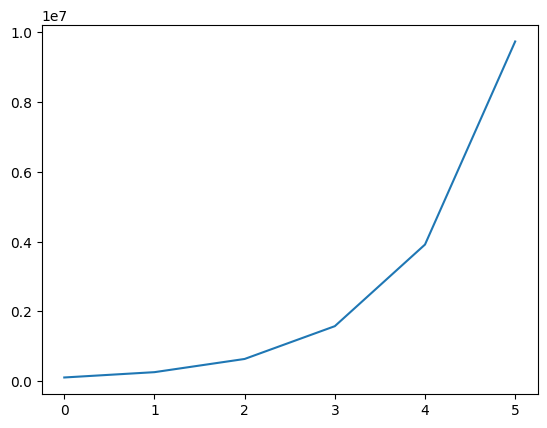

In [17]:
import seaborn as sns

sns.lineplot(x=range(len(test)), y=test)